In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize, StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_digits

from sklearn.naive_bayes import GaussianNB

# https://github.com/mrahtz/machine-learning-classification/blob/master/module6_cross-validation-and-grid-search.py
# https://www.codementor.io/mgalarny/making-your-first-machine-learning-classifier-in-scikit-learn-python-db7d7iqdh
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html
# http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

## Вопросы:

0. + какой алгоритм страдает от избытка инфы    -> проклятие размерности
0. + выставить все фичи, и глубину получше, отсортировать признаки по важности 
0. фичи из дерева в кнн. stacking
 #сократим выборку -> '''resize images to 28x28 -> tree -> best_features to knn
 на original mnist 
 фичи из дерева в кнн. stacking

0. log-regressiya


# 3 Task

In [4]:
# mnist = fetch_mldata('MNIST original') #имеют размер 28x28
# sz = 28
mnist = load_digits()
sz = 8



X, y = mnist.data, mnist.target
rnd_state = np.random.randint(0, X.shape[0])
print(X.shape, rnd_state)

(1797, 64) 405


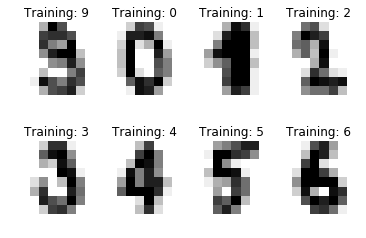

In [5]:
images_and_labels = list(zip(X, y))

for index, (image, label) in enumerate(images_and_labels[rnd_state:rnd_state + 8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape([sz,sz]), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [6]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=rnd_state)
X_holdout.shape

(540, 64)

In [20]:
tree = DecisionTreeClassifier(max_depth=5, random_state=rnd_state)
knn = KNeighborsClassifier(n_neighbors=10)

tree.fit(X_train, y_train)
knn.fit(X_train, y_train)

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=rnd_state)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9625724910039694


In [6]:
tree_pred = tree.predict(X_holdout)
print(accuracy_score(y_holdout, tree_pred))

knn_pred = knn.predict(X_holdout)
print(accuracy_score(y_holdout, knn_pred))

0.6518518518518519
0.975925925925926


## Cross Val Tree

In [7]:
tree_params = {'max_depth': [2**i for i in range(6)],
'max_features': [2**i for i in range(6)]}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

In [8]:
tree_grid.fit(X_train, y_train)
print("Fit end")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fit end


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.3s finished


In [9]:
print(tree_grid.best_params_, tree_grid.best_score_)

{'max_depth': 16, 'max_features': 32} 0.8361177406523469


In [10]:
print(accuracy_score(y_holdout, tree_grid.predict(X_holdout)))

0.8518518518518519


## Cross Val KNN

In [11]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [12]:
knn_grid.fit(X_train, y_train)
print("Fit end")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fit end


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.8s finished


In [13]:
print(knn_grid.best_params_, knn_grid.best_score_)

{'knn__n_neighbors': 5} 0.9713603818615751


In [14]:
print(accuracy_score(y_holdout, knn_grid.predict(X_holdout)))

0.9777777777777777


## Cross Val Forest

In [15]:
forest_params = {'max_depth': [2**i for i in range(6)],
'max_features': [2**i for i in range(6)]}

forest_grid = GridSearchCV(forest, forest_params,
cv=5, n_jobs=-1,
verbose=True)

In [16]:
forest_grid.fit(X_train, y_train)
print("Fit end")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   23.2s finished


Fit end


In [17]:
print(forest_grid.best_params_, forest_grid.best_score_)

{'max_depth': 32, 'max_features': 4} 0.9769291964996022


In [18]:
print(accuracy_score(y_holdout, forest_grid.predict(X_holdout)))

0.975925925925926


## Naive Bayes

In [19]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [20]:
gnb_pred = gnb.predict(X_holdout) # Нечего подбирать
print(accuracy_score(y_holdout, gnb_pred))

0.8055555555555556


## 2 Вопрос

In [21]:
tree = DecisionTreeClassifier(max_depth=5, random_state=rnd_state)
tree_params = {'max_depth': [2**i for i in range(6)],
'max_features': [X.shape[1]]}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)

In [22]:
tree_grid.fit(X_train, y_train)
print("Fit end")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fit end


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [23]:
print(tree_grid.best_params_, tree_grid.best_score_)

{'max_depth': 8, 'max_features': 64} 0.8178202068416865


In [24]:
print(accuracy_score(y_holdout, tree_grid.predict(X_holdout)))

0.8092592592592592


In [25]:
fi = tree_grid.best_estimator_.feature_importances_
len(fi)

64

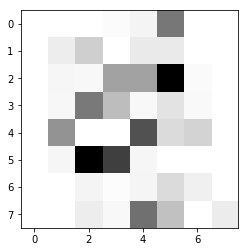

In [26]:
plt.imshow(fi.reshape([sz,sz]), cmap=plt.cm.gray_r, interpolation='nearest')


# SVC

In [12]:
from sklearn import svm
svc = svm.SVC(gamma=0.001, C=100.)
svm_params = {'gamma': [0.0, 0.001, 0.05, 0.1], 
              #'max_iter': range(2, 20), 
              'C': [1., 5., 10., 20., 40., 100.]}
svm_grid = GridSearchCV(svc, svm_params,cv=5, n_jobs=-1,verbose=False)
svm_grid.fit(X_train, y_train)
print(svm_grid.best_params_)
print('best SVC on train ', svm_grid.best_score_)
pred = svm_grid.predict(X_holdout)
print('SVC on Test ', accuracy_score(y_holdout, pred))  

{'C': 5.0, 'gamma': 0.001}
best SVC on train  0.984884645982498
SVC on Test  0.9925925925925926


# LogisticRegression

In [14]:
from sklearn.linear_model import LogisticRegression
logRegr = LogisticRegression(
    random_state=rnd_state,
    solver='lbfgs',
    multi_class='multinomial')

log_params = {
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']
}

regr_grid = GridSearchCV(logRegr, log_params, cv=5, n_jobs=-1,verbose=True)
regr_grid.fit(X_train, y_train)


print(regr_grid.best_params_)
print('best Regression on train ', regr_grid.best_score_)
pred = regr_grid.predict(X_holdout)
print('Regression on Test ', accuracy_score(y_holdout, pred)) 
#

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

{'solver': 'newton-cg'}
best Regression on train  0.958631662688942
Regression on Test  0.9611111111111111


## 3 Вопрос

In [74]:
mnist = fetch_mldata('MNIST original') #имеют размер 28x28
sz = 28

max_sz = 8000

X, y = mnist.data, mnist.target

X = X[:max_sz].astype('float64')
y = y[:max_sz]
rnd_state = np.random.randint(0, X.shape[0])
print(X.shape, rnd_state)



(8000, 784) 5708


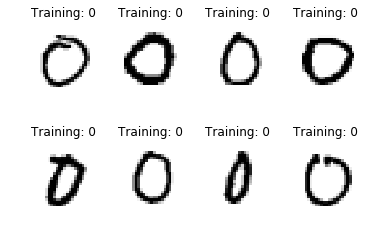

In [75]:
images_and_labels = list(zip(X, y))

for index, (image, label) in enumerate(images_and_labels[rnd_state:rnd_state + 8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape([sz,sz]), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [76]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
random_state=rnd_state)
print(X_holdout.shape)

images_and_labels = list(zip(X_train, y_train))

for index, (image, label) in enumerate(images_and_labels[rnd_state:rnd_state + 8]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape([sz,sz]), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

(2400, 784)


In [77]:
tree = DecisionTreeClassifier(max_depth=5, random_state=rnd_state)
knn = KNeighborsClassifier(n_neighbors=10)

tree_params = {'max_depth': [2**i for i in range(8)],
'max_features': [2**i for i in range(10)] + [784]}

tree_grid = GridSearchCV(tree, tree_params,
cv=5, n_jobs=-1,
verbose=True)


knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

knn_params = {'knn__n_neighbors': [2**i for i in range(3)]}

knn_grid = GridSearchCV(knn_pipe, knn_params,
cv=5, n_jobs=-1,
verbose=True)



In [78]:
tree_grid.fit(X_train, y_train)
print("Fit end")
print(tree_grid.best_params_, tree_grid.best_score_)
print(accuracy_score(y_holdout, tree_grid.predict(X_holdout)))
fi = tree_grid.best_estimator_.feature_importances_
len(fi)

Fitting 5 folds for each of 88 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.6s


Fit end
{'max_depth': 16, 'max_features': 32} 0.9946428571428572
0.9908333333333333


[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:   36.8s finished


784

In [79]:
knn_grid.fit(X_train, y_train)
print("Fit end")
print(knn_grid.best_params_, knn_grid.best_score_)
print(accuracy_score(y_holdout, knn_grid.predict(X_holdout)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


Fit end
{'knn__n_neighbors': 4} 0.9966071428571428
0.9945833333333334


In [83]:
X_train[:, fi <= 0] = 0
X_holdout[:, fi <= 0] = 0

In [84]:
knn_grid.fit(X_train, y_train)
print("Fit end")
print(knn_grid.best_params_, knn_grid.best_score_)
print(accuracy_score(y_holdout, knn_grid.predict(X_holdout)))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


Fit end
{'knn__n_neighbors': 1} 0.99875
0.9979166666666667
